# Thinking Probabilistically 

In [1]:
#| echo: false
import polars as pl 
import polars.selectors as cs
from scipy.special import binom, beta
import preliz as pz
from great_tables import GT 

## A Probability Primer for Bayesian Practitioners 

###  Sample space and events 

Lets say we go out and ask 3 random respondents a series of three questions and record their answers. There are lots of ways we could represent. In @tbl-samp-space I remix the example in the book a bit but the core idea is the same. The *sample space* is the set of all possible outcomes. 

In [2]:
#| echo: false
#| label: tbl-samp-space
sample_space = pl.DataFrame({
    'Person 1': ['yes', 'yes', 'yes'],
    'Person 2': ['no', 'no', 'no'],
    'Question': ['1', '2', '3']
}).unpivot(on = cs.contains('Person'), index = 'Question', variable_name='Individual', value_name='Response')

GT(sample_space)

Question,Individual,Response
1,Person 1,yes
2,Person 1,yes
3,Person 1,yes
1,Person 2,no
2,Person 2,no
3,Person 2,no


In our case, we are just talking about the order of each person's responses. An event is a subset of the feature space, so we can think of it as the order in which people respond to the questions. So there are eight possible *combinations* of answer orders. For brevity, I only include two of those events. If we wanted to know how likely it is that we observe an event, we can express it as a simple proportion. 

$$
P(Event) = \frac{\text{event we are interested in}}{\text{total number of events}}
$$

So if we are interested in the all yes event, it is just `{python} 1/8`. If we make the assumption that the events are independent of each other then the probability of observing an event where the respondent answers all yes and another respondent answers all no than we can represent that as:

$$
P(\text{All Yes and No}) = \frac{1}{8} + \frac{1}{8} = \frac{2}{8} = 0.25
$$


Fast forward a bit the three axioms of probability are: 

1. The probability of an event is an even is a non-negative real number 
2. The probability of P(sample space) = 1
3. If 𝐴1, 𝐴2,… are disjoint events, meaning they cannot occur simultaneously then
𝑃(𝐴1, 𝐴2, …) = 𝑃(𝐴1) + 𝑃(𝐴2) + …

### Random Variables 


A random variable is effectively a function that maps the sample space the real numbers. So we can think of that as. Doing something akin to: 


In [3]:
#| echo: false
ex = sample_space.with_columns(
    pl.when(pl.col('Response') == 'yes').then(1).otherwise(0).alias('Mapping Examp')
)

GT(ex)

Question,Individual,Response,Mapping Examp
1,Person 1,yes,1
2,Person 1,yes,1
3,Person 1,yes,1
1,Person 2,no,0
2,Person 2,no,0
3,Person 2,no,0


The author uses the example of a set of Python code. So if the take example from `pl.when(thing_happens).then(do this).otherwise(do that)` this is an abstraction over a set of Rust code that takes our inputs and then maps them to our desired output. We could theoretically write out all this Rust code every single time. But we package it in a nice set of functions to make the end user's code cleaner and reusable we make some functions to do this. 

Random variables play this similar role in stats where we have some inputs like responses to a survey or temperature that get mapped onto some process. There is no randomness when moving from "yes" to "one", but there *is* some randomness when we go to the survey the third and fourth person to get their event. 

### Discrete random variables and their distributions

We generally don't care about the kidns of problems that get presented in these refreshers. The probability of 3 inidividuals answering all yes or the probability of getting a one on the dice. In general we are more intersted in getting a list of probabilities for all possible answers. We can then get the possibilities of any sort of event we would care about. As a simple heuristic the list of the probabilities are effectively just this list of probabilities. So if we wanted to get the proportion of heads of 1000 flipped coins we could do this. 

(array([  1.,   0.,   0.,   2.,   2.,   3.,  31., 888.,  72.,   1.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667]),
 <BarContainer object of 10 artists>)

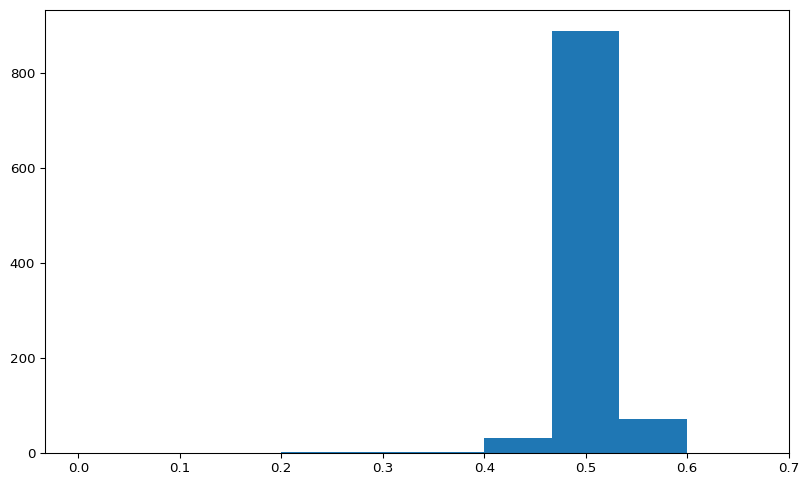

In [4]:
#| label: fig-coin-flips
#| echo: false
import numpy as np 
import matplotlib.pyplot as plt 

flips = np.random.choice(['heads', 'tails'], size = 1000, replace = True)

coin_flips = pl.DataFrame({
    'heads_proportion': np.cumsum(flips == 'heads')/np.arange(1, 1000 + 1),
    'flip_number': np.arange(1, 1000 + 1)
})

plt.figure(figsize=(10,6))
plt.hist(coin_flips['heads_proportion'])


In this case the probability distribution of a coin flip is a Bernouli distribution. When we have multiple Bernouli trials we can stack them and make a binomial. One thing about these functions is that they have, for lack of a better term, shape parameters. For a normal those are our mean and standard deviation for something like the beta binomial in `rbinom()` it is `rbinom(shape1 = 2, shape2 = 9)` which changes where the most likely outcomes are. 


Text(-0.04, 0.4, 'P(X=x)')

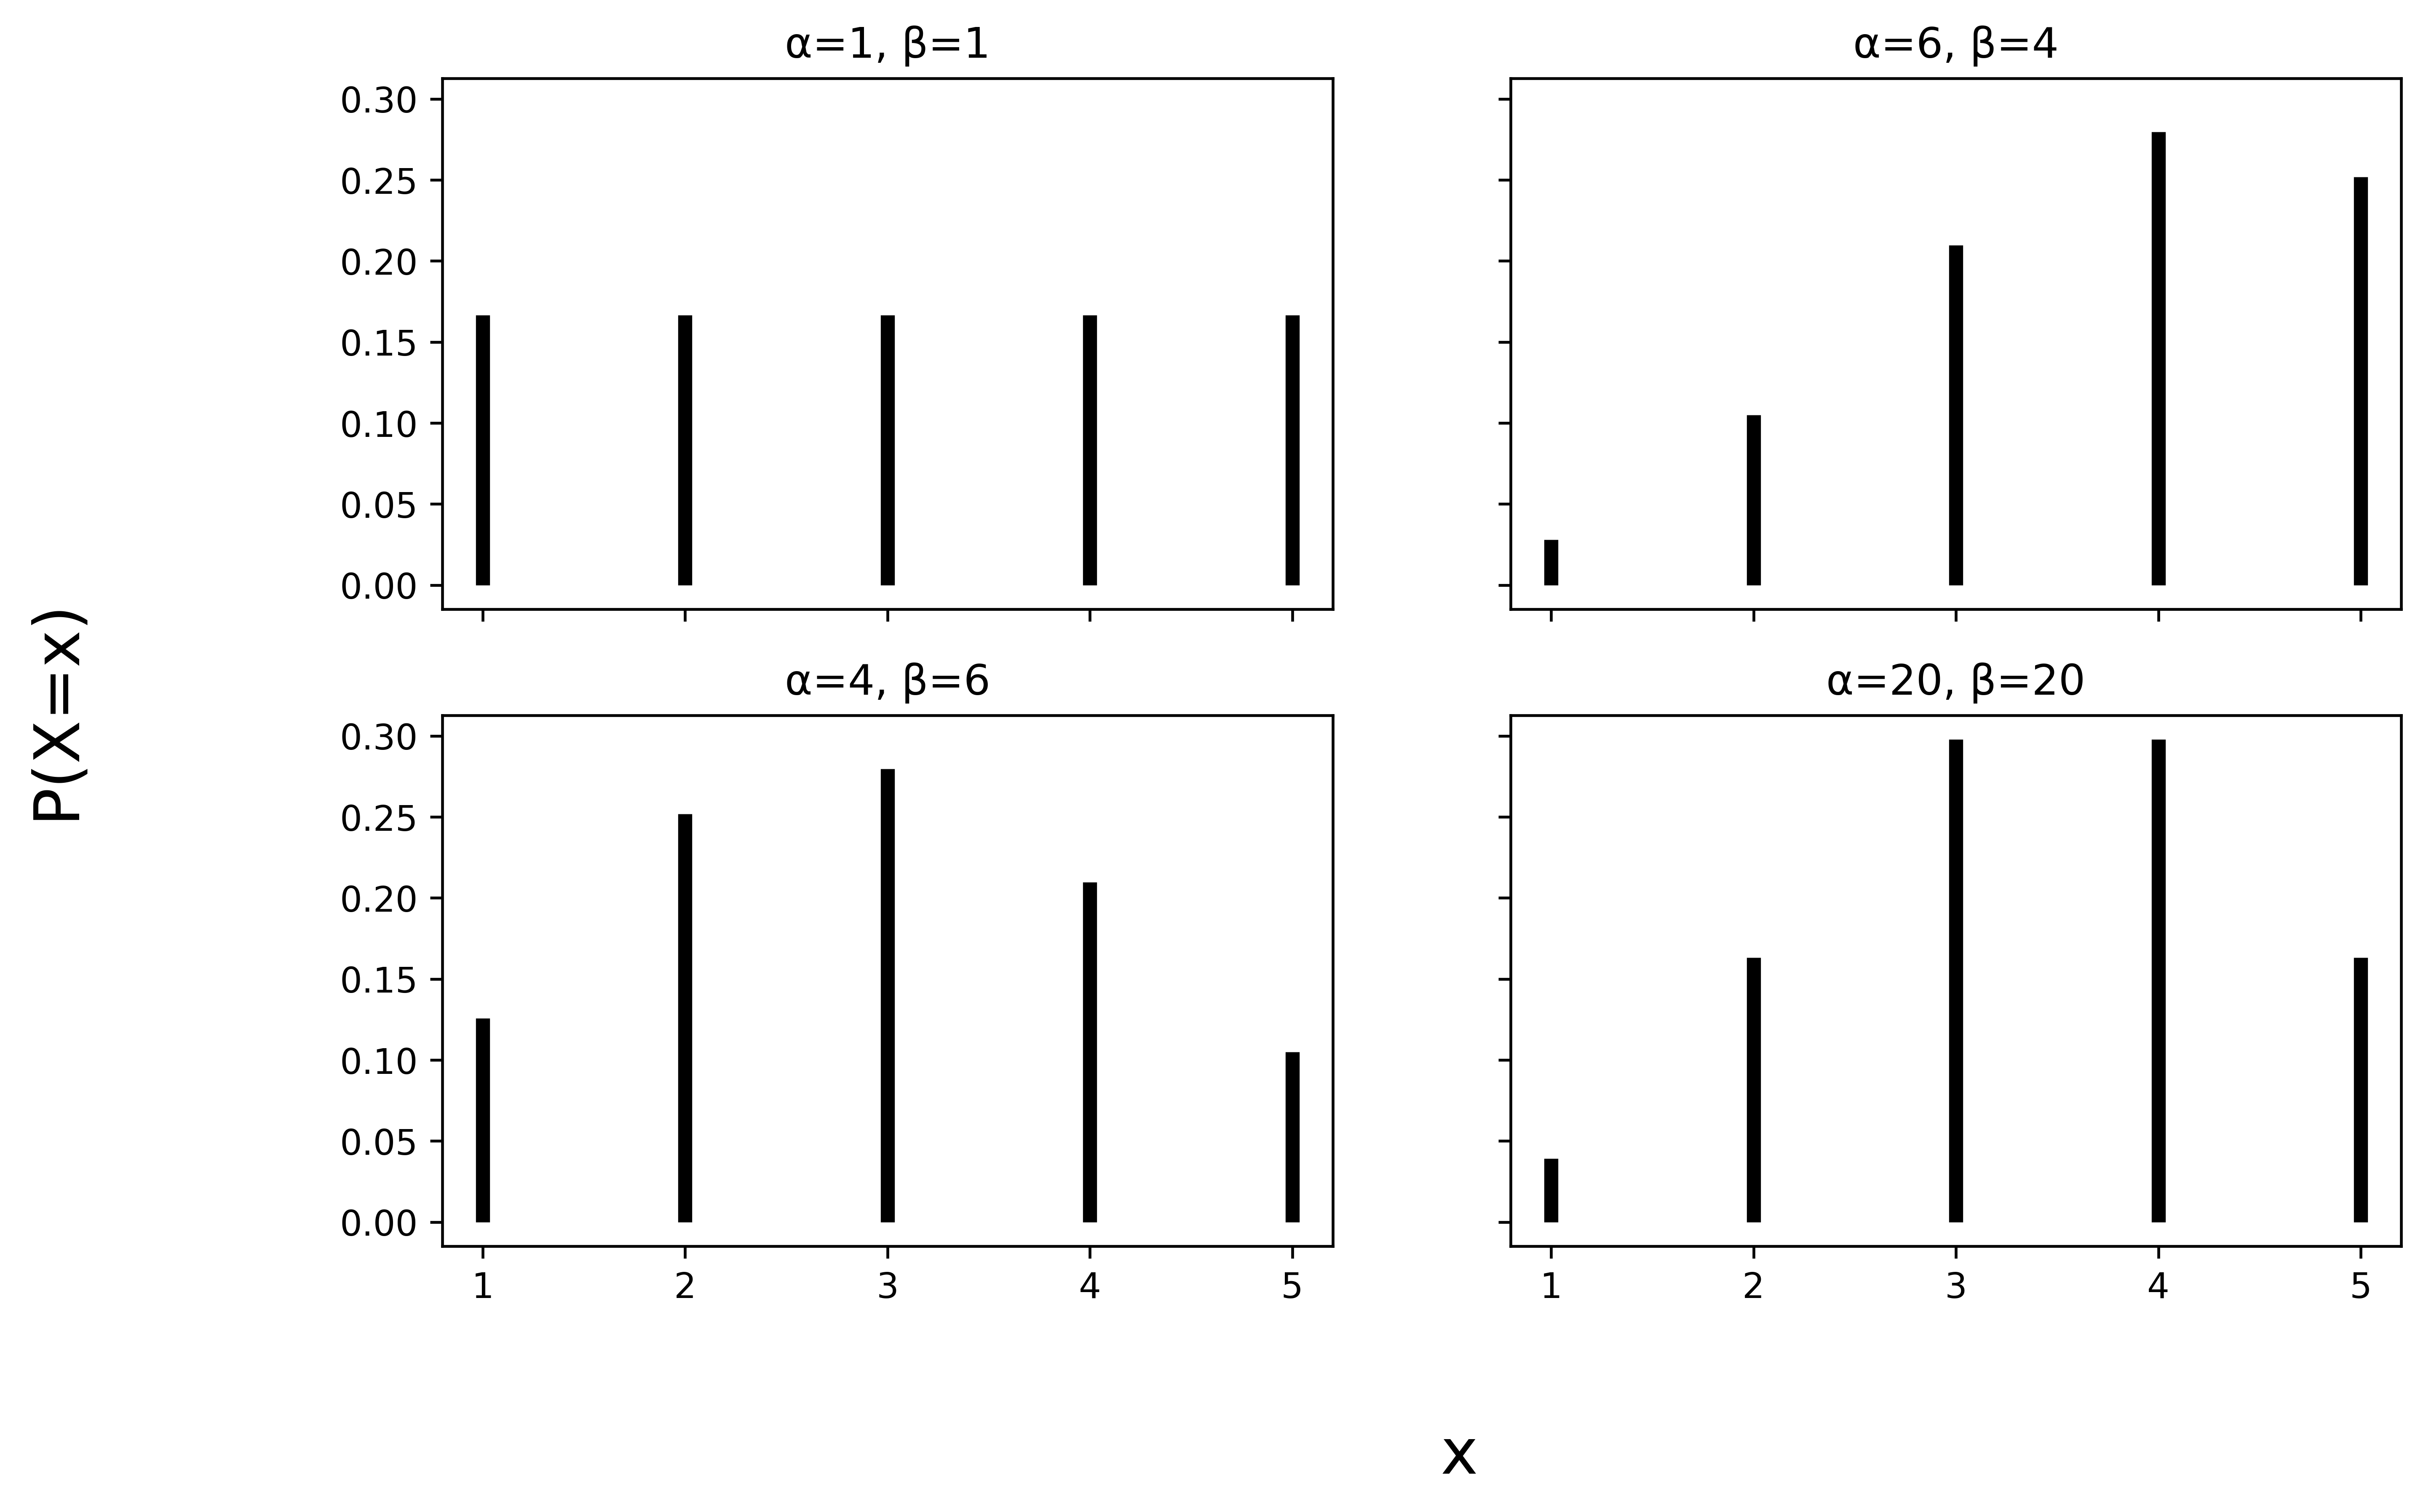

In [5]:
#| code-fold: true

np.random.seed(1994)

from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])

plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=600)

n = 5

x = np.arange(0,5)
fig, axes = plt.subplots(2,2, figsize = (10,6), sharey= True, sharex = True)
axes = np.ravel(axes)


for ax, (alpha, bt) in zip(axes, ((1,1), (6,4),(4,6), (20,20))):
    dist_pmf = binom(n, x) * (beta(x+alpha, n-x+bt) / beta(alpha, bt))
    ax.vlines(x, 0, dist_pmf, colors = 'C0', lw=4)
    ax.set_title(f"α={alpha}, β={bt}")
    ax.set_xticks(x)
    ax.set_xticklabels(x + 1)

fig.text(0.52, -0.04, "x", fontsize=18)
fig.text(-0.04, 0.4, "P(X=x)", fontsize=18, rotation="vertical")

While this is helpful for us as we are toying around with setting priors or as pedagogy. The thing that is doing the heavy lifting of mapping things to the like P(thing) = 0.6 is the probability mass function. This works for discrete data because you can't have 1.5 heads. I eschew including it but one really helpful thing to help us wrap our heads around what changing the shape parameters of our distribution are is using the interactive plots. 


In [6]:
bb = pz.BetaBinomial(alpha = 10, beta = 10, n = 6)

bb.plot_interactive(figsize = (10,6), pointinterval=False, xy_lim =(20,20))


interactive(children=(FloatSlider(value=10.0, description='alpha (0, inf)', max=110.0, min=2.220446049250313e-…

### Conditional Probablities 

From the highest level of abstraction all our models are really just fancy conditional probability machines. Given an outcome variable how does it change if we observe these 1 to a million things. To keep it more manageable than lets just consider the bivariate case. If we are trying to understand how something about how good an NFL team is we might want to look at their EPA and condition on adjusted games lost. The more games that a team's best players lose the worse their EPA is going to be. By knowing something about EPA we know a little bit something about their 

We would anticipate that the higher a team's EPA is the less adjusted games lost they have. If we plot the marginal distributions we can see that. Quickly to compute the marginal distribution of AGL we are going to take the p(AGL, EPA) and then we average over EPA.
